In [3]:
import pandas as pd
import os
import pydicom as dicom
import cv2
from matplotlib import pyplot as plt
import numpy as np
import SimpleITK as sitk
import nrrd
from skimage import morphology
from skimage import img_as_ubyte

In [4]:
#Set path to dcm and nrrd files 
image_path = os.path.join("C:/Users/samkr/Downloads/DICOM FILES/annotated/9012435 Annotated")
segmented_path = os.path.join(image_path, "annotated", "9012435-label.nrrd")

In [5]:

    #Obtain files from path 
    slice_filenames = sitk.ImageSeriesReader_GetGDCMSeriesFileNames(image_path)  
    image = sitk.ReadImage(slice_filenames)
    segmentation = sitk.ReadImage(segmented_path)
    #set variables
    current_slice = image[:, :, 5]
    current_seg_slice = segmentation[:, :, 5]
    
    current_img = sitk.GetArrayFromImage(current_slice)
    current_seg = sitk.GetArrayFromImage(current_seg_slice)



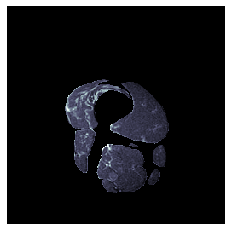

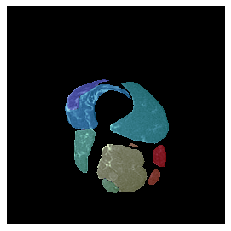

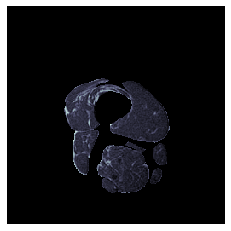

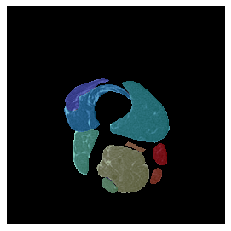

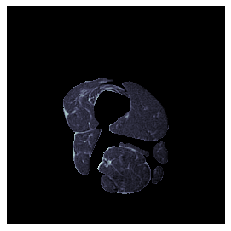

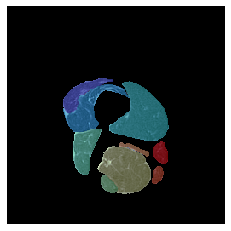

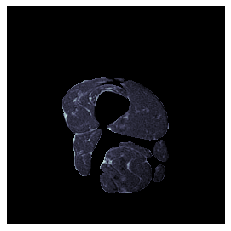

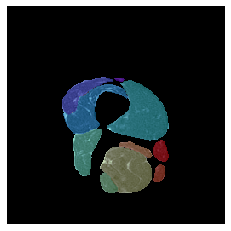

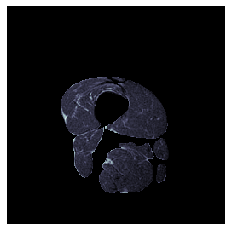

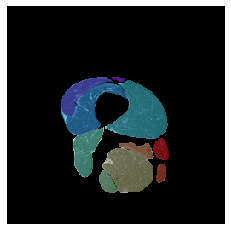

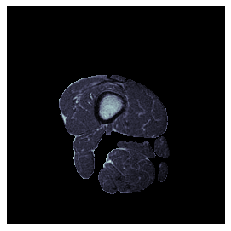

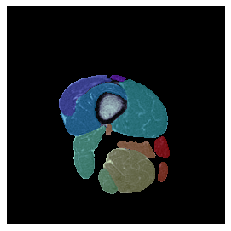

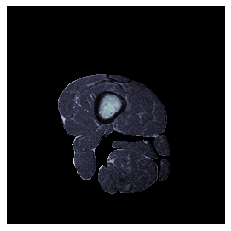

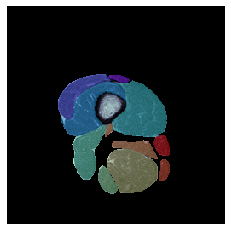

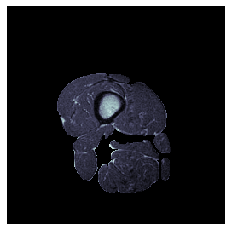

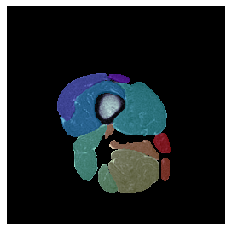

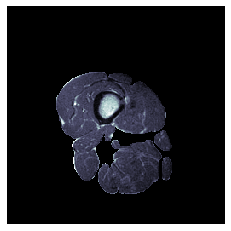

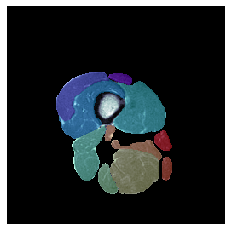

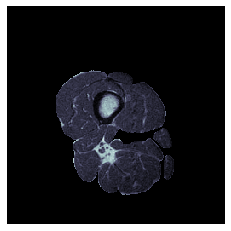

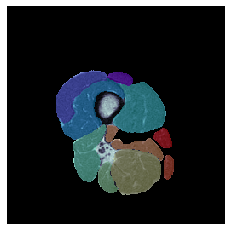

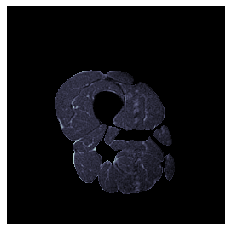

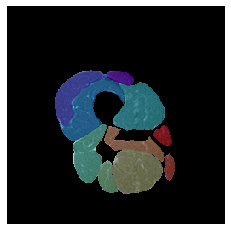

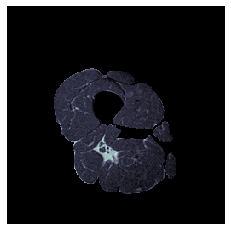

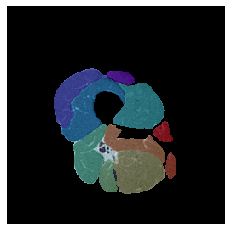

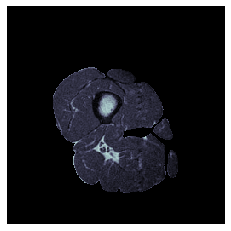

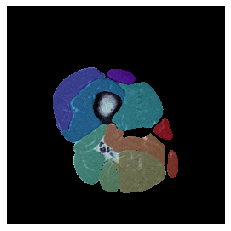

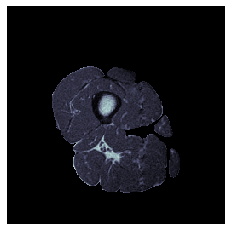

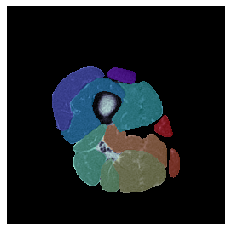

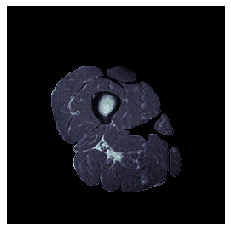

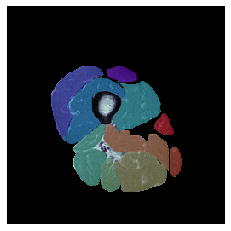

<Figure size 432x288 with 0 Axes>

In [20]:
count=0
slicevalue=image.GetSize()[2]//15
while count<15:
    current_slice = image[:, :, count]
    current_seg_slice = segmentation[:, :, count]
    current_img = sitk.GetArrayFromImage(current_slice)
    current_seg = sitk.GetArrayFromImage(current_seg_slice)
    make_mask(current_img,current_seg)
    count+=1

    
    

In [6]:
def check_sizes(image,segmentation):
    iS = image.GetSize()
    iO = image.GetOrigin()
    iD = image.GetDirection()
    iC = image.GetSpacing()
    
    sS = segmentation.GetSize()
    sO = segmentation.GetOrigin()
    sD = segmentation.GetDirection()
    sC = segmentation.GetSpacing()
    
    if (iS==sS and iC==sC):
        return 1




In [7]:
def show_middle_slice(image,segmentation):
    current_slice = image[:, :, 1] # extract the middle slice of the image
    array_from_image = sitk.GetArrayFromImage(image) # numpy array is reversed and metadata on image info lost
    image_from_array = sitk.GetImageFromArray(array_from_image)
    
    current_seg_slice = segmentation[:, :,1]

    plt.imshow(sitk.GetArrayFromImage(current_slice), cmap="bone")
    plt.show()
    plt.imshow(sitk.GetArrayFromImage(current_seg_slice), cmap="bone")
    plt.show()
    
    

In [14]:
def overlay_segmentation(image, segmentation):
    if isinstance(image, sitk.Image):
        image = sitk.GetArrayFromImage(image)
    if isinstance(segmentation, sitk.Image):
        segmentation = sitk.GetArrayFromImage(segmentation)

    overlay = np.ma.masked_where(segmentation == 0, segmentation)
    plt.axis('off')
    plt.imshow(image, cmap="bone",vmin=0, vmax=2200)
    plt.imshow(overlay, cmap="rainbow", vmin=1, vmax=10, alpha=0.4)
    plt.show()

In [19]:
def make_mask(current_img,current_seg):
    currentsegmask = (current_seg > 0) # create mask by setting 0 values to transparent
    currentimgc = currentsegmask*current_img

    plt.imshow(currentsegmask, cmap='Greys')

    type(currentsegmask)
    # convert int16 to uint8 
    im_in = cv2.normalize(src=current_seg, dst=None, alpha=0.0, beta=10.0, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # Threshold.
    # Set values above 0 to equal 1.
    th, im_th = cv2.threshold(im_in, 0, 1, cv2.THRESH_BINARY_INV);

    # Copy the thresholded image.
    im_floodfill = im_th.copy()
    
    # Mask used to flood filling.
    # Notice the size needs to be 2 pixels than the image.
    h, w = im_th.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)

    # Floodfill from point (0, 0)
    cv2.floodFill(im_floodfill, mask, (0,0), 255);

    # Invert floodfilled image
    im_floodfill_inv = cv2.bitwise_not(im_floodfill)

    # Combine the two images to get the foreground.
    im_out = im_th | im_floodfill_inv

    current_mask = (im_out > 1)
    current_masked = current_img * current_mask


    plt.imshow(current_masked, cmap="bone")
    
    #gfdsg
    y=0
    x=0
    h=current_slice.GetSize()[0]//2
    w=256
    current_segcr = current_seg[y:y+h, x:x+w]
    current_maskedcr = current_masked[y:y+h, x:x+w]

    plt.axis('off')
    
    plt.imshow(current_maskedcr, cmap="bone",vmin=0, vmax=2200)
    plt.show()
    plt.imshow(current_segcr, cmap="tab10", vmin=1, vmax=10, alpha=0.4)
    overlay_segmentation(current_maskedcr,current_segcr)
    plt.clf()
    

 
